In [1]:
!wget https://raw.githubusercontent.com/bikash4044/TuteDude/refs/heads/main/Data%20Science/Assignment7/heart.csv

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [3]:
plt.rcParams['figure.dpi']  = 200
sns.set(rc={'axes.facecolor':'#faded9'}, style = 'darkgrid')

In [4]:
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [5]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [6]:
continuous_features = ['age','trestbps','chol','thalach', 'oldpeak']
features_to_convert = [feature for feature in df.columns if feature not in continuous_features]
df[features_to_convert] = df[features_to_convert].astype('object')
df.dtypes

age           int64
sex          object
cp           object
trestbps      int64
chol          int64
fbs          object
restecg      object
thalach       int64
exang        object
oldpeak     float64
slope        object
ca           object
thal         object
target       object
dtype: object

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1025.0,54.434146,9.072290,29.0,48.0,56.0,61.0,77.0
trestbps,1025.0,131.611707,17.516718,94.0,120.0,130.0,140.0,200.0
chol,1025.0,246.000000,51.592510,126.0,211.0,240.0,275.0,564.0
thalach,1025.0,149.114146,23.005724,71.0,132.0,152.0,166.0,202.0
oldpeak,1025.0,1.071512,1.175053,0.0,0.0,0.8,1.8,6.2


In [8]:
df.describe(include='object')

,sex,cp,fbs,restecg,exang,slope,ca,thal,target
count,1025,1025,1025,1025,1025,1025,1025,1025,1025
unique,2,4,2,3,2,3,5,4,2
top,1,0,0,1,0,1,0,2,1
freq,713,497,872,513,680,482,578,544,526


### EDA

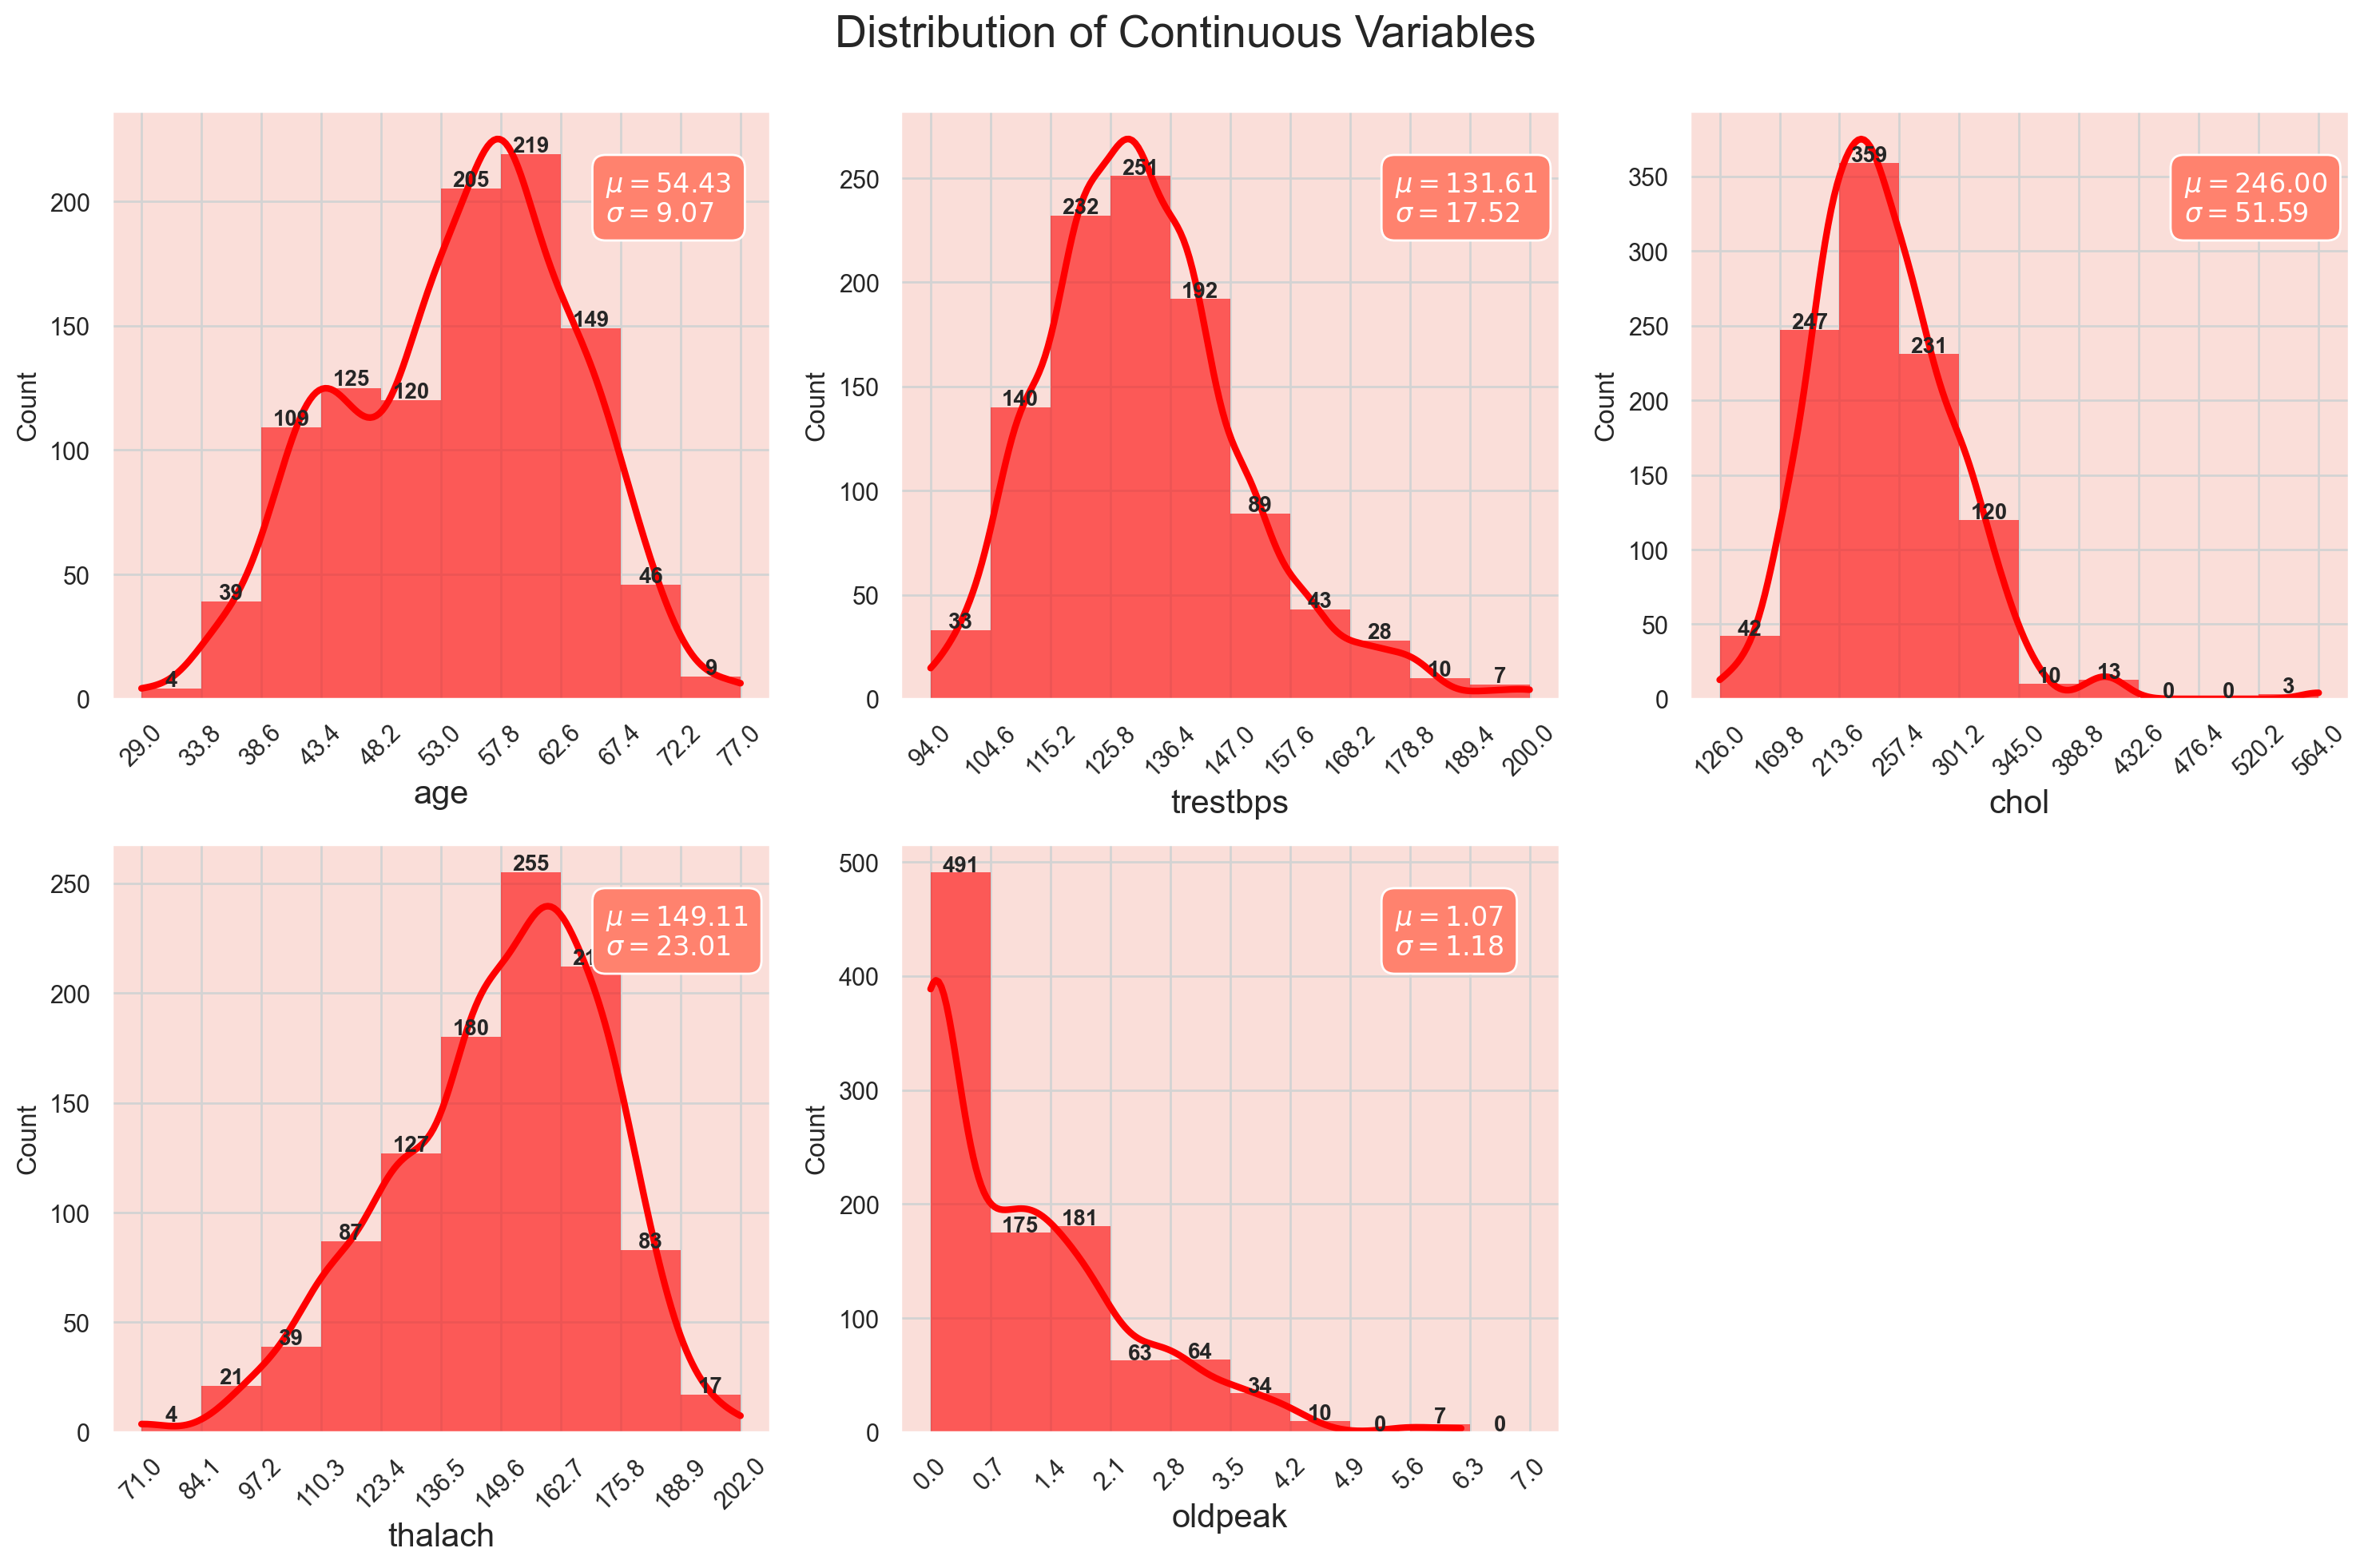

In [9]:
# Univariate analysis

df_continuous = df[continuous_features]

fig,ax = plt.subplots(nrows=2, ncols =3, figsize=(15,10))

# Loop to plot histograms for each continuous feature
for i, col in enumerate(df_continuous.columns):
    x = i // 3
    y = i % 3
    values, bin_edges = np.histogram(df_continuous[col], 
                                     range=(np.floor(df_continuous[col].min()), np.ceil(df_continuous[col].max())))
    
    graph = sns.histplot(data=df_continuous, x=col, bins=bin_edges, kde=True, ax=ax[x, y],
                         edgecolor='none', color='red', alpha=0.6, line_kws={'lw': 3})
    ax[x, y].set_xlabel(col, fontsize=15)
    ax[x, y].set_ylabel('Count', fontsize=12)
    ax[x, y].set_xticks(np.round(bin_edges, 1))
    ax[x, y].set_xticklabels(ax[x, y].get_xticks(), rotation=45)
    ax[x, y].grid(color='lightgrey')

    for j, p in enumerate(graph.patches):
        ax[x, y].annotate('{}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height() + 1),
                          ha='center', fontsize=10, fontweight="bold")
        
    textstr = '\n'.join((
        r'$\mu=%.2f$' % df_continuous[col].mean(),
        r'$\sigma=%.2f$' % df_continuous[col].std()
    ))
    ax[x, y].text(0.75, 0.9, textstr, transform=ax[x, y].transAxes, fontsize=12, verticalalignment='top',
                  color='white', bbox=dict(boxstyle='round', facecolor='#ff826e', edgecolor='white', pad=0.5))

ax[1,2].axis('off')
plt.suptitle('Distribution of Continuous Variables', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()



In [10]:
# categorical variable univariate analysis
categorical_features = df.columns.difference(continuous_features)
df_categorical = df[categorical_features]

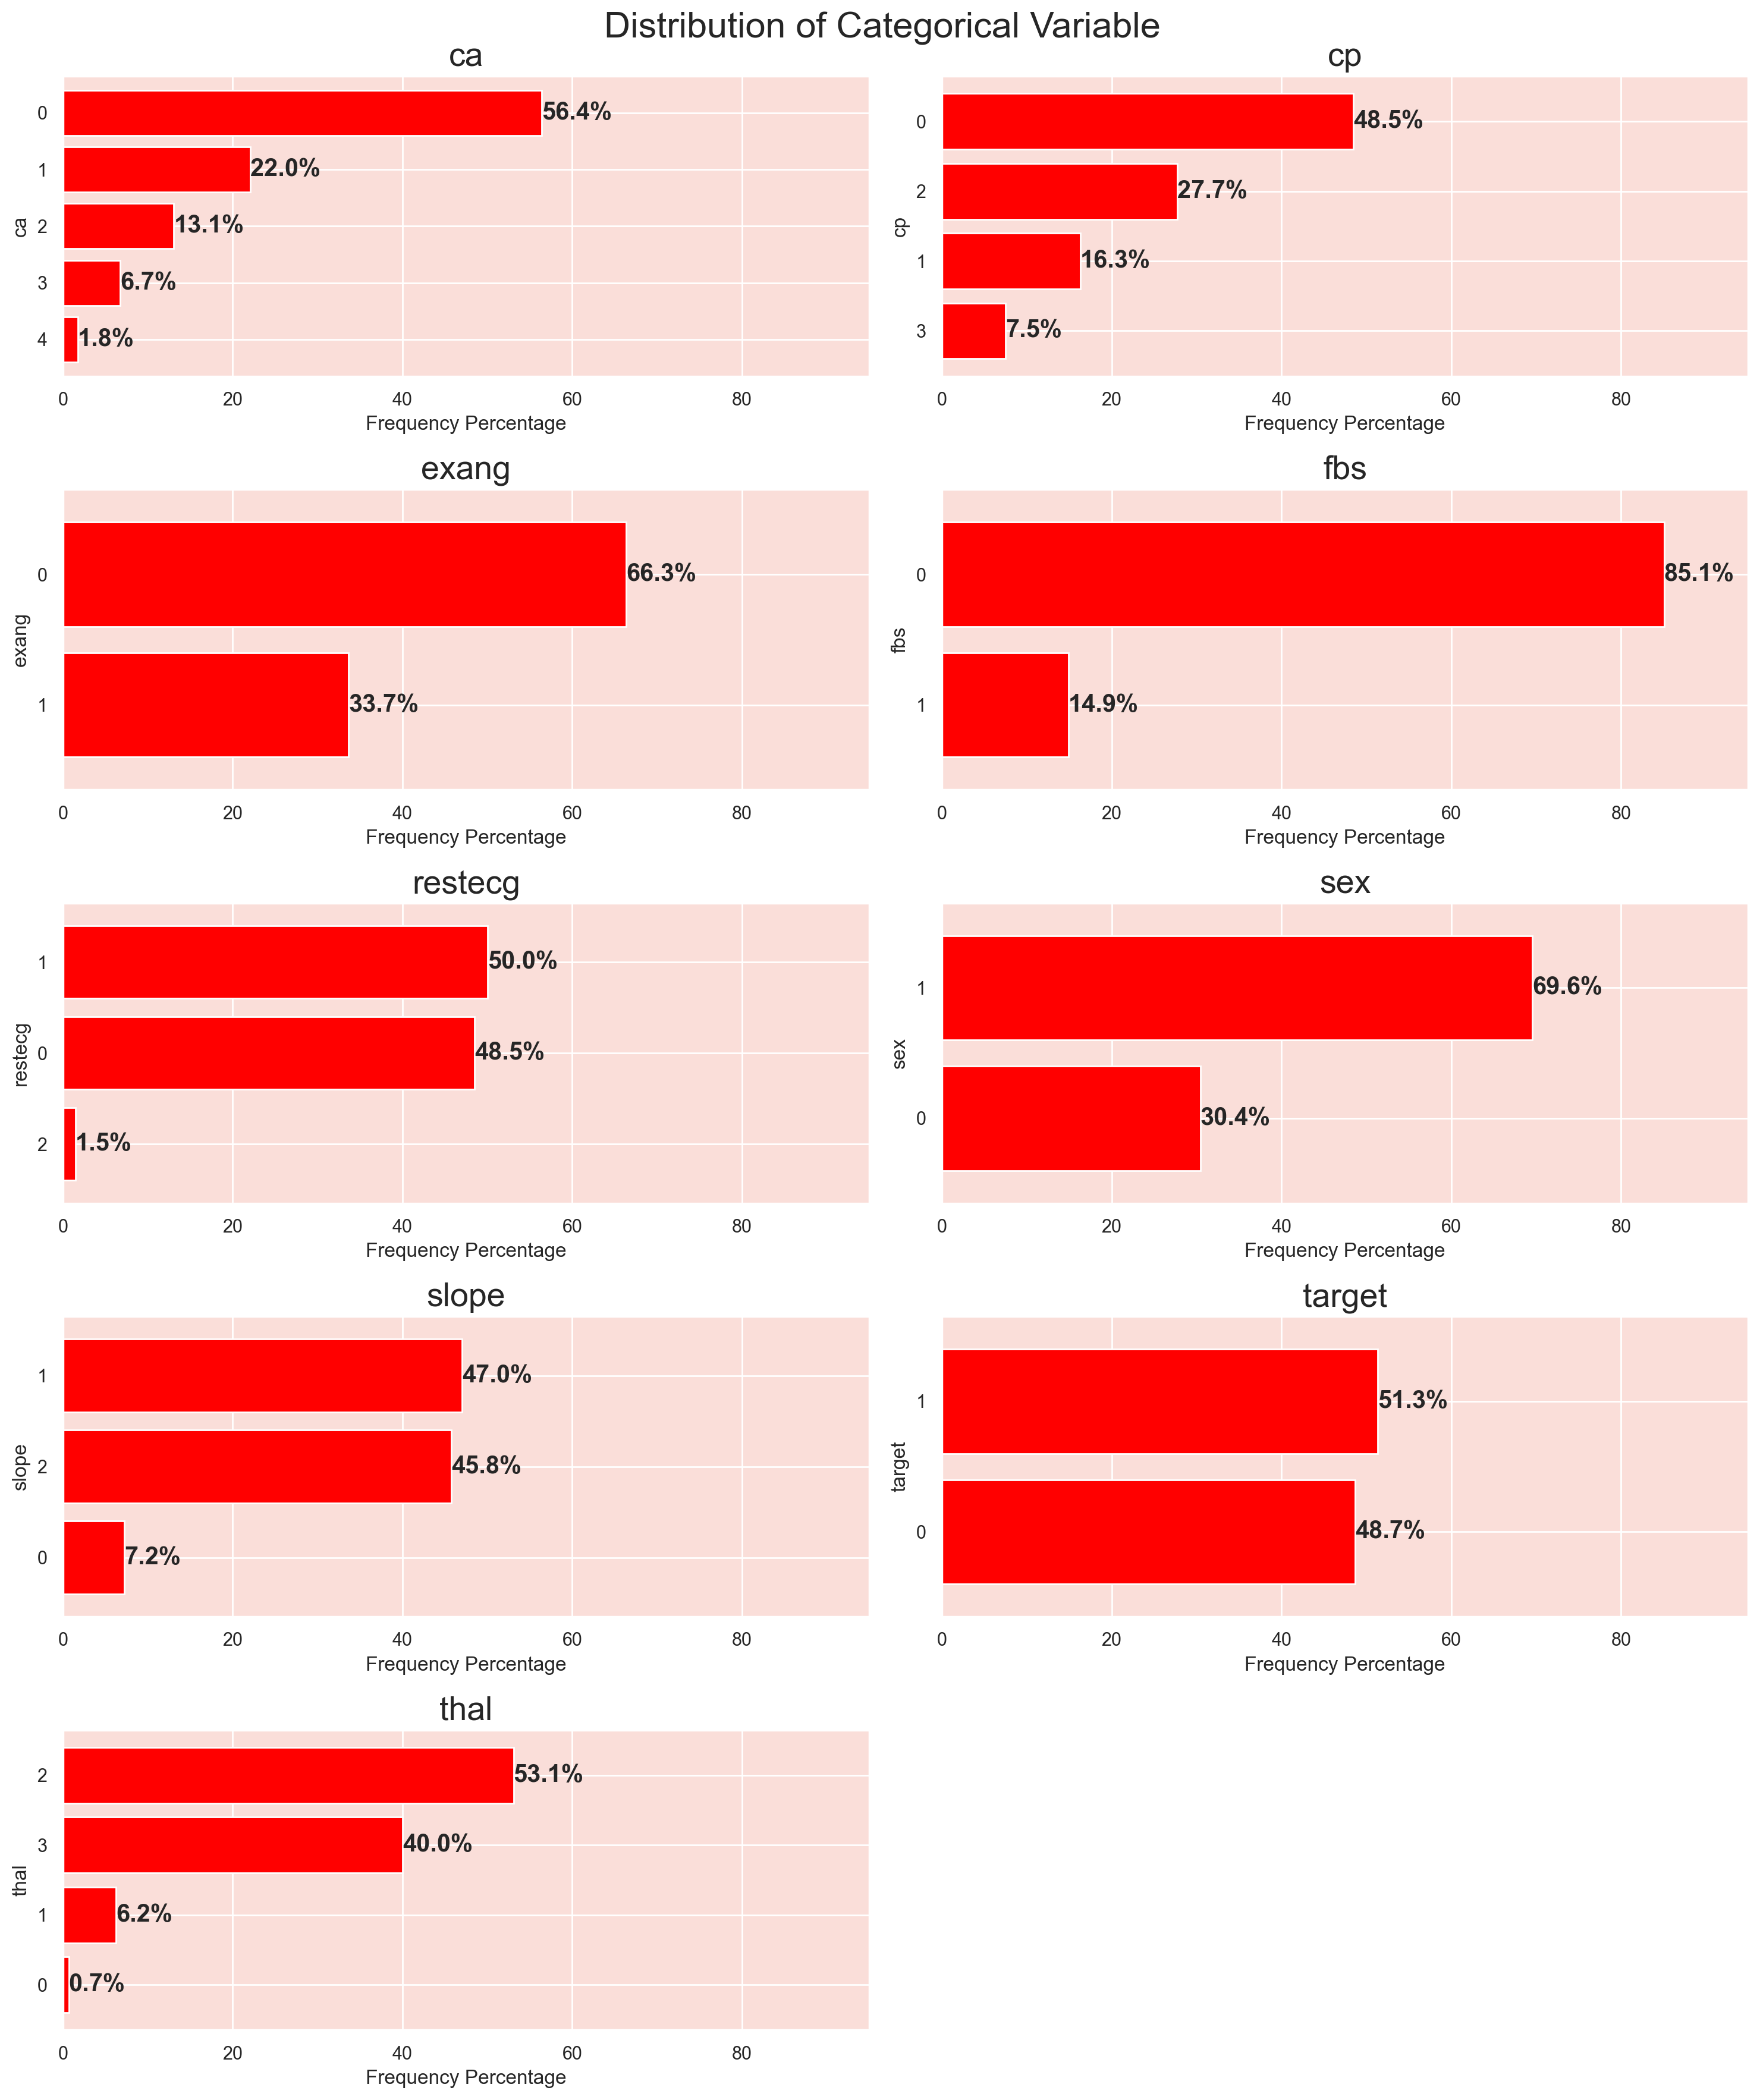

In [11]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15,18))

for i, col in enumerate(categorical_features):
    row = i //2
    col_idx = i%2

    value_counts = df[col].value_counts(normalize=True).mul(100).sort_values()

    value_counts.plot(kind='barh', ax=ax[row, col_idx], width=0.8, color='red')

    for index, value in enumerate(value_counts):
        ax[row,col_idx].text(value, index, str(round(value,1))+'%', fontsize=15, weight='bold',va='center')

    ax[row,col_idx].set_xlim([0,95])
    ax[row,col_idx].set_xlabel('Frequency Percentage', fontsize=12)
    ax[row,col_idx].set_title(f'{col}', fontsize=20)

ax[4,1].axis('off')
plt.suptitle('Distribution of Categorical Variable', fontsize=22)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

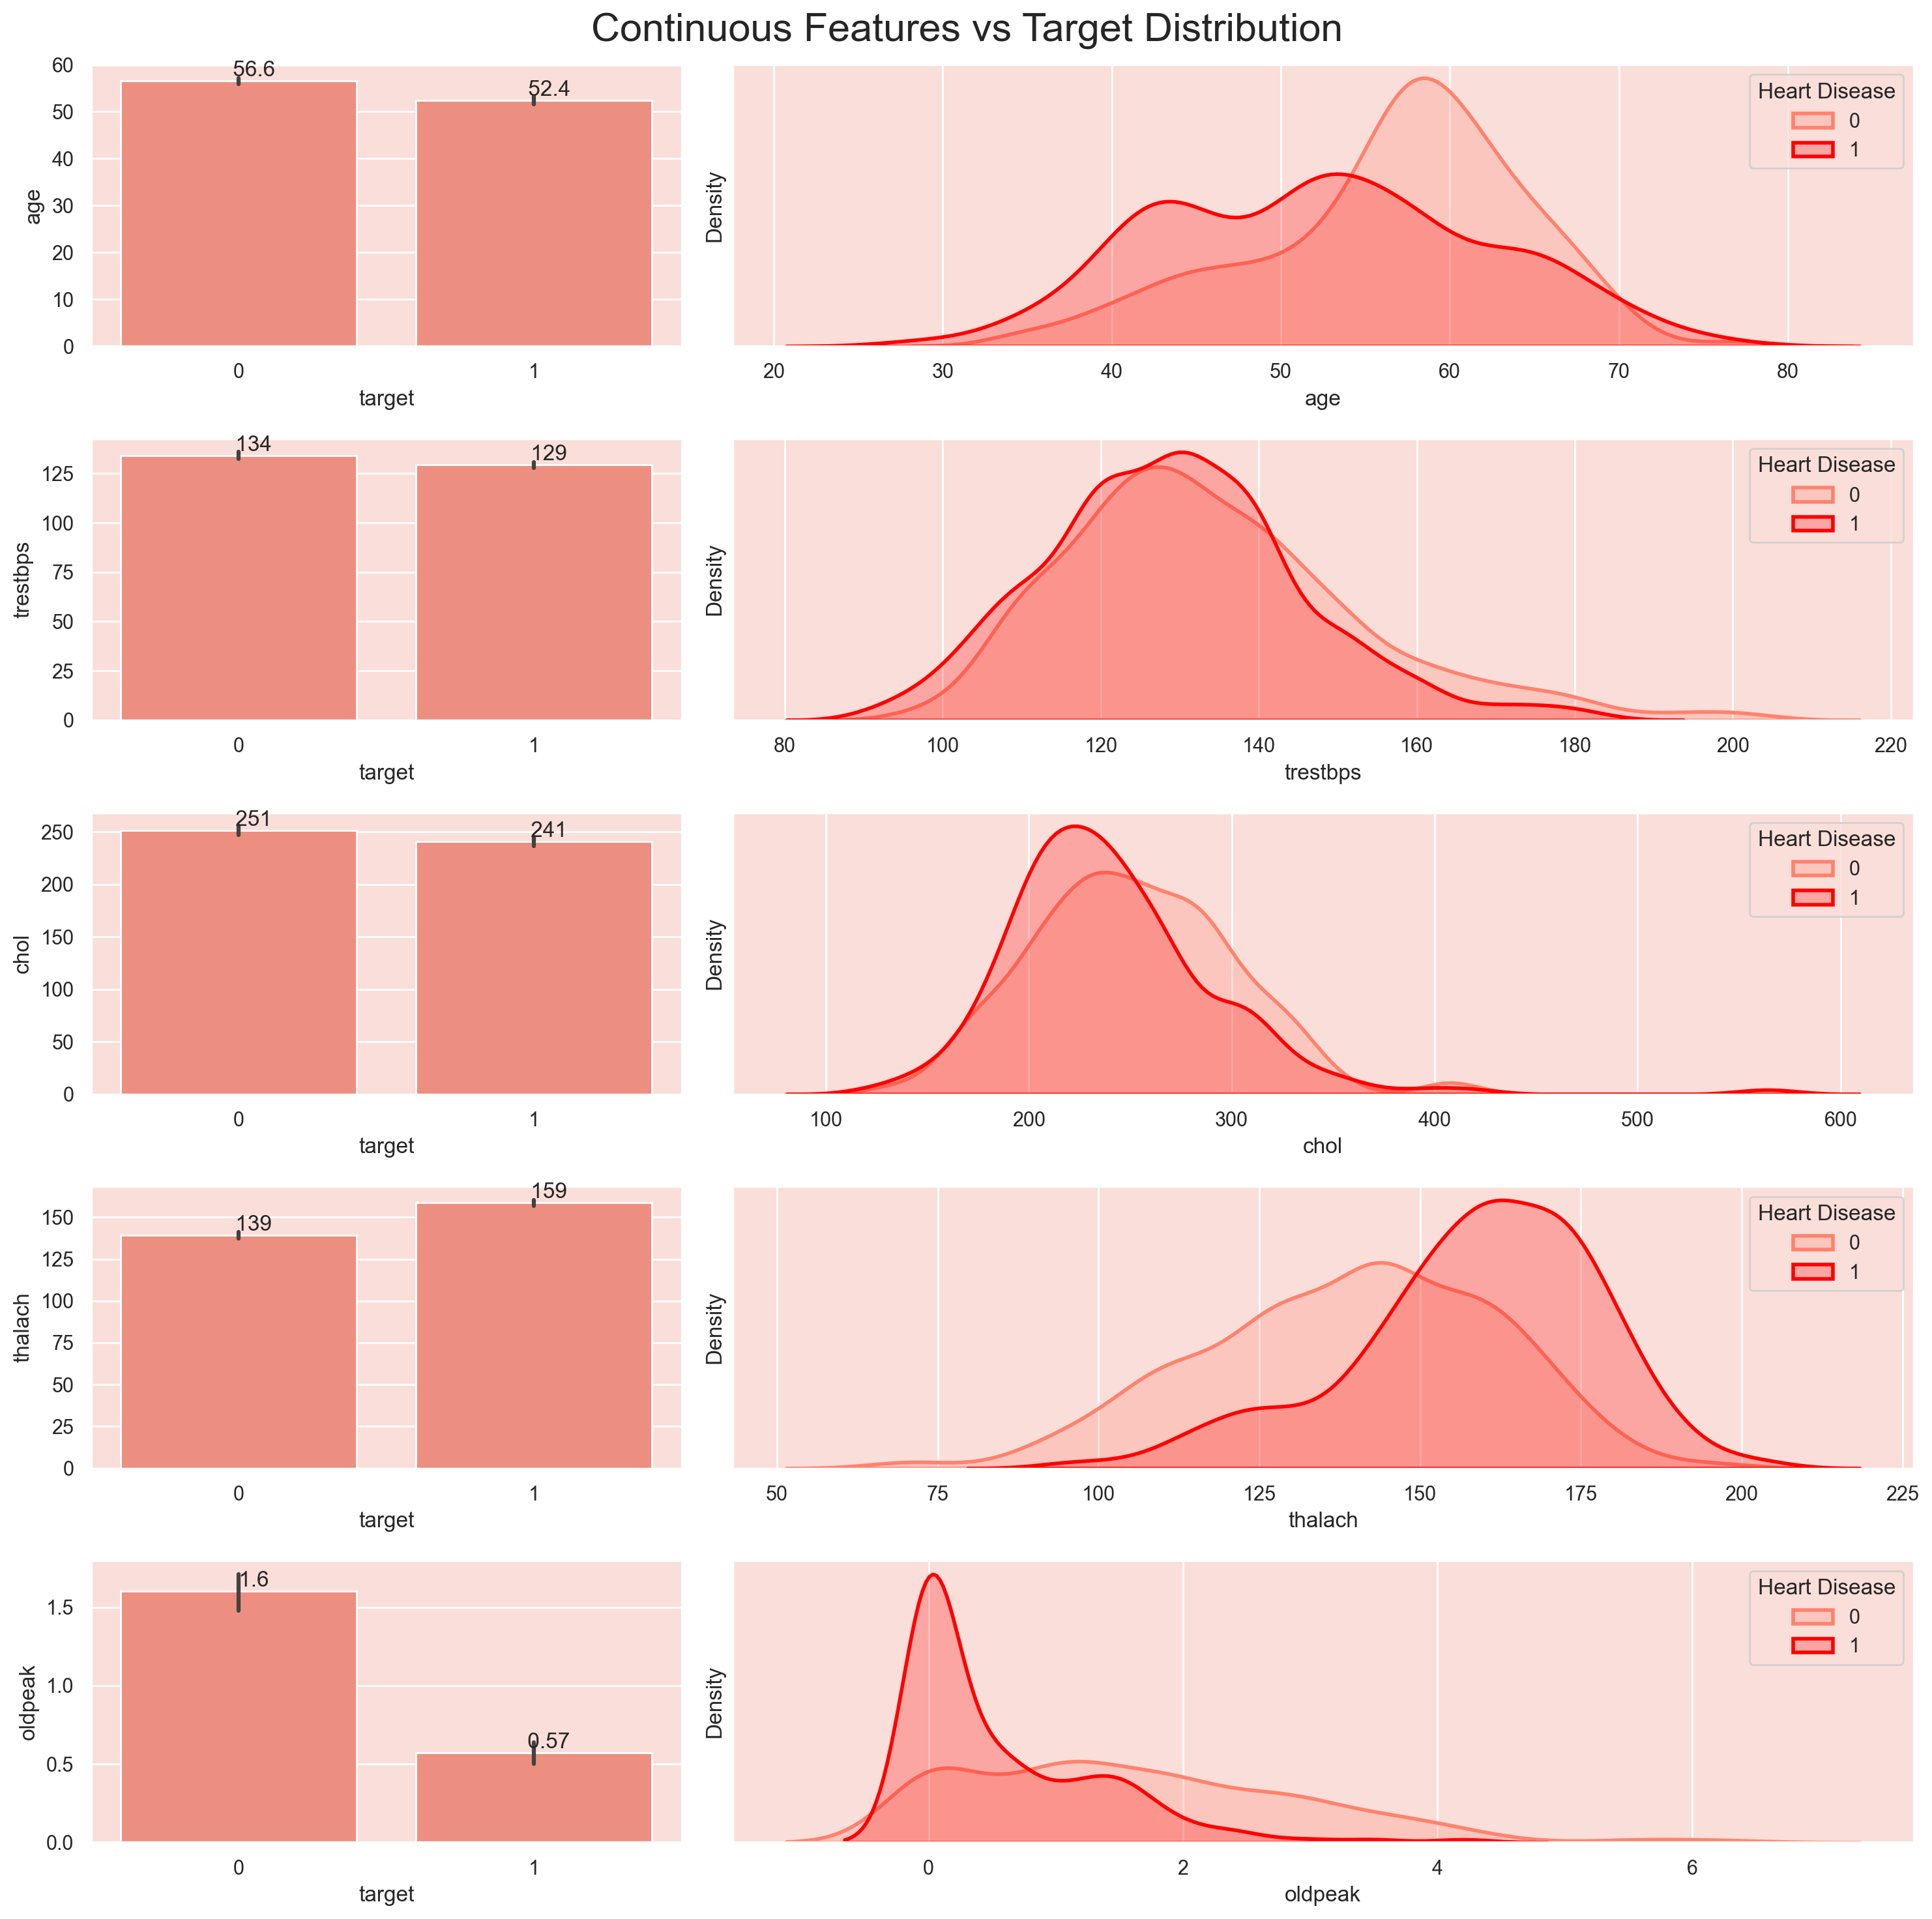

In [12]:
#Bivariate analysis
sns.set_palette(['#ff826e', 'red'])

fig,ax = plt.subplots(len(continuous_features), 2, figsize=(15,15), gridspec_kw={'width_ratios':[1,2]})


for i, col in enumerate(continuous_features):
    graph = sns.barplot(data=df, x='target', y=col, ax=ax[i,0])

    sns.kdeplot(data=df[df["target"]==0], x=col, fill=True, linewidth=2, ax=ax[i,1], label='0')
    sns.kdeplot(data=df[df["target"]==1], x=col, fill=True, linewidth=2, ax=ax[i,1], label='1')
    ax[i,1].set_yticks([])
    ax[i,1].legend(title="Heart Disease", loc="upper right")

    for cont in graph.containers:
        graph.bar_label(cont, fmt='     %.3g')

plt.suptitle('Continuous Features vs Target Distribution', fontsize=22)
plt.tight_layout()
plt.show()


In [13]:
categorical_features = [feature for feature in categorical_features if feature != 'target']

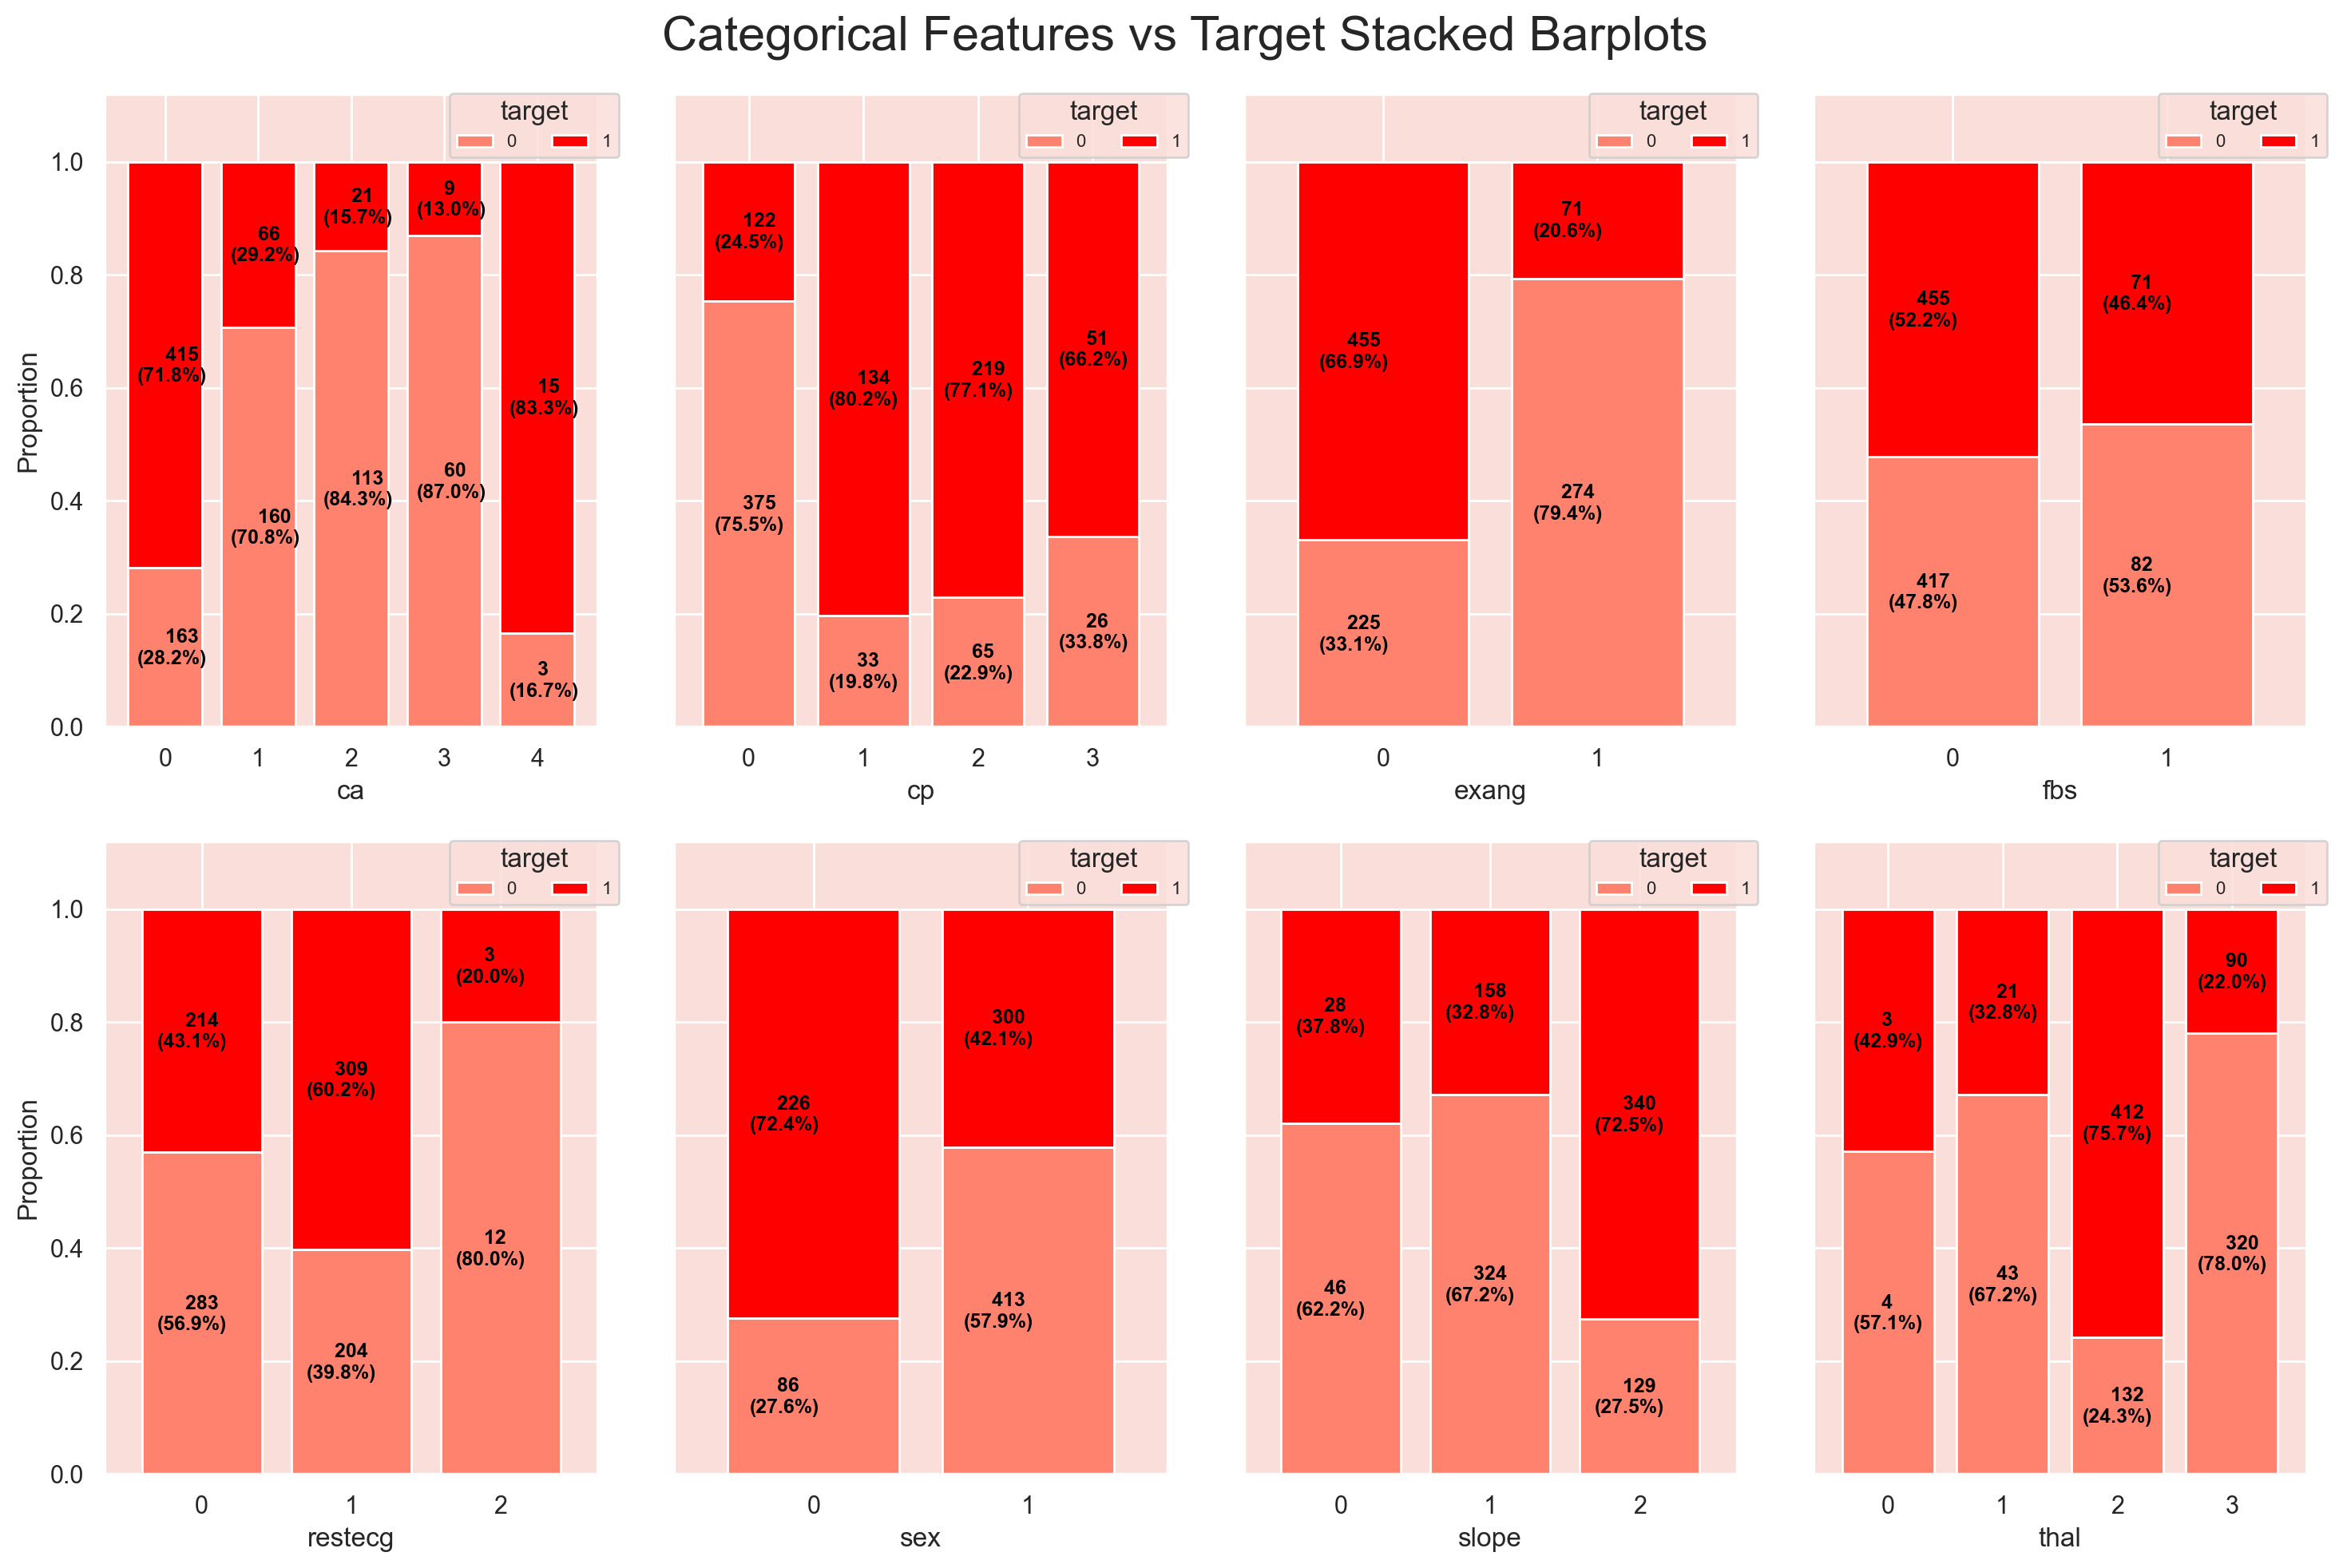

In [14]:
fig,ax = plt.subplots(nrows=2, ncols=4, figsize=(15,10))

for i,col in enumerate(categorical_features):
    
    # Create a cross tabulation showing the proportion of purchased and non-purchased loans for
    cross_tab = pd.crosstab(index=df[col], columns=df['target'])
    
    # Using the normalize=True argument gives us the index-wise proportion of the data
    cross_tab_prop = pd.crosstab(index=df[col], columns=df['target'], normalize='index')
    
    # Define colormap
    cmp = ListedColormap(['#ff826e', 'red'])
    
    # Plot stacked bar charts
    x, y = i//4, i%4
    cross_tab_prop.plot(kind='bar', ax=ax[x,y], stacked=True, width=0.8, colormap=cmp,
                        legend=False, ylabel='Proportion', sharey=True)

        # Add the proportions and counts of the individual bars to our plot
    for idx, val in enumerate([*cross_tab.index.values]):
        for (proportion, count, y_location) in zip(cross_tab_prop.loc[val],cross_tab.loc[val],cross_tab_prop.loc[val].cumsum()):
            ax[x,y].text(x=idx-0.3, y=(y_location-proportion)+(proportion/2)-0.03,
                         s = f'     {count}\n({np.round(proportion * 100, 1)}%)',
                         color = "black", fontsize=9, fontweight="bold")

    # Add Legend
    ax[x,y].legend(title='target', loc=(0.7,0.9), fontsize=8, ncol=2)
    # Set y limit
    ax[x,y].set_ylim([0,1.12])
    # Rotate xticks
    ax[x,y].set_xticklabels(ax[x,y].get_xticklabels(), rotation=0)

plt.suptitle('Categorical Features vs Target Stacked Barplots', fontsize=22)
plt.tight_layout()
plt.show()


### Data Preprocessing

In [15]:
df.isnull().sum().sum()

np.int64(0)

#### Outlier treatment

In [16]:
Q1 = df[continuous_features].quantile(0.25)
Q3 = df[continuous_features].quantile(0.75)

IQR = Q3-Q1
outliers_count_specified = ((df[continuous_features] < (Q1 - 1.5*IQR)) | (df[continuous_features] > (Q3+1.5*IQR))).sum()

outliers_count_specified

age          0
trestbps    30
chol        16
thalach      4
oldpeak      7
dtype: int64

In [17]:
df_encoded = pd.get_dummies(df, columns=['cp', 'restecg', 'thal'], drop_first=True)

features_to_convert = ['sex', 'fbs', 'exang', 'slope', 'ca', 'target']
for feature in features_to_convert:
    df_encoded[feature] = df_encoded[feature].astype(int)

df_encoded.dtypes

age            int64
sex            int64
trestbps       int64
chol           int64
fbs            int64
thalach        int64
exang          int64
oldpeak      float64
slope          int64
ca             int64
target         int64
cp_1            bool
cp_2            bool
cp_3            bool
restecg_1       bool
restecg_2       bool
thal_1          bool
thal_2          bool
thal_3          bool
dtype: object

In [18]:
df_encoded.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,target,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
0,52,1,125,212,0,168,0,1.0,2,2,0,False,False,False,True,False,False,False,True
1,53,1,140,203,1,155,1,3.1,0,0,0,False,False,False,False,False,False,False,True
2,70,1,145,174,0,125,1,2.6,0,0,0,False,False,False,True,False,False,False,True
3,61,1,148,203,0,161,0,0.0,2,1,0,False,False,False,True,False,False,False,True
4,62,0,138,294,1,106,0,1.9,1,3,0,False,False,False,True,False,False,True,False


### Feature Scaling

In [19]:
X = df_encoded.drop('target', axis=1)
y = df_encoded['target']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0, stratify=y)

In [21]:
continuous_features

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [22]:
X_train['oldpeak'] = X_train['oldpeak'] + 0.001
X_test['oldpeak'] = X_test['oldpeak'] + 0.001

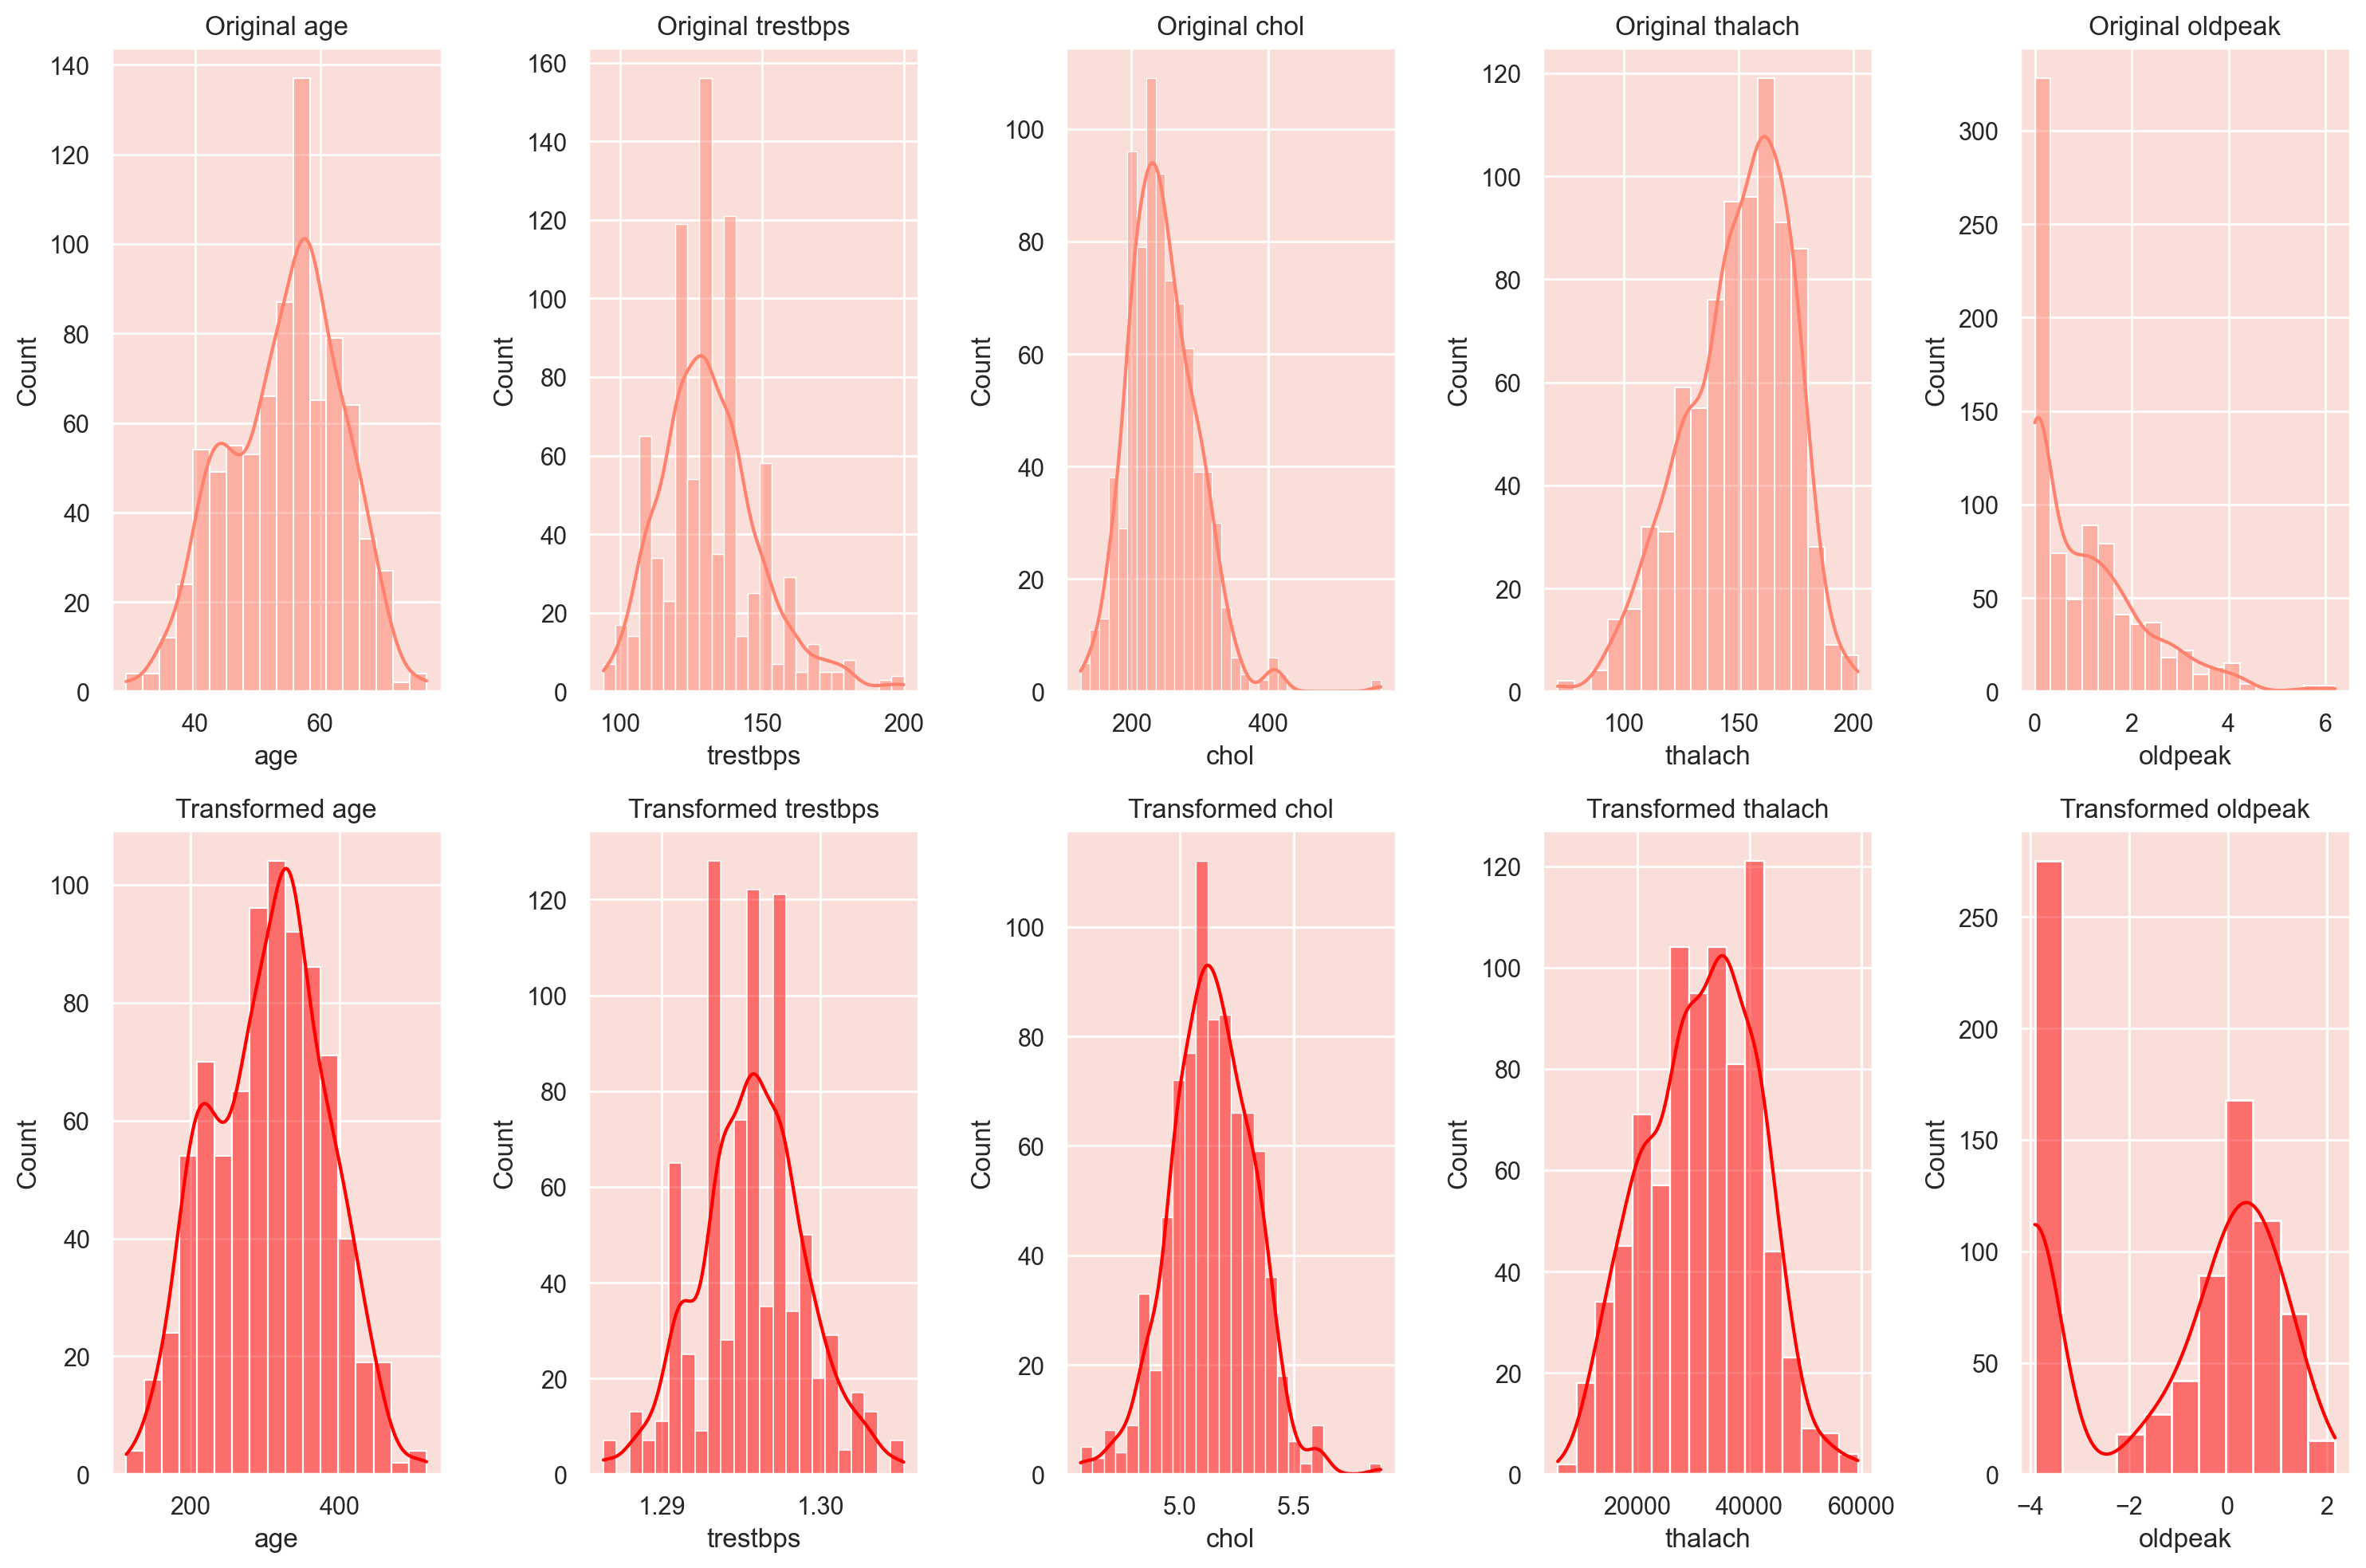

In [23]:
fig,ax = plt.subplots(2,5,figsize=(15,10))

for i,col in enumerate(continuous_features):
    sns.histplot(X_train[col], kde=True, ax=ax[0,i], color='#ff826e').set_title(f'Original {col}')


lambdas={}

for i, col in enumerate(continuous_features):
    if X_train[col].min()>0:
        X_train[col], lambdas[col] = boxcox(X_train[col])
        X_test[col] = boxcox(X_test[col], lmbda = lambdas[col])
        sns.histplot(X_train[col], kde=True, ax = ax[1,i], color='red').set_title(f"Transformed {col}")
    else:
        sns.histplot(X_train[col], kde=True, ax = ax[1,i], color='green').set_title(f"{col} (Not Transformed)")

fig.tight_layout()
plt.show()

In [24]:
X_train.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
397,188.243856,1,1.291178,4.818111,0,16654.592901,1,0.739965,1,0,False,False,False,False,False,False,False,True
687,333.780047,1,1.294735,5.333017,0,40983.789741,0,-3.905686,2,2,False,False,False,False,False,False,False,True
909,265.549657,1,1.298293,4.977381,0,20800.169014,1,-0.103254,1,0,False,False,False,False,False,False,False,True
153,298.985470,1,1.293636,5.201130,0,29291.926122,0,-0.840949,1,0,False,True,False,False,False,False,False,True
373,333.780047,1,1.293636,5.285145,0,35357.536287,0,0.621445,1,0,True,False,False,False,False,False,True,False


### Decision Tree Model Building

In [25]:
dt_base = DecisionTreeClassifier(random_state=0)

In [26]:
def tune_clf_hyperparameters(clf, param_grid, X_train, y_train, scoring='recall', n_splits=3):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring=scoring, n_jobs=-1)
    clf_grid.fit(X_train, y_train)
    best_hyperparameters = clf_grid.best_params_
    return clf_grid.best_estimator_, best_hyperparameters

In [27]:
param_grid_dt = {
    'criterion':['gini','entropy'],
    'max_depth':[2,3],
    'min_samples_split':[2,3,4],
    'min_samples_leaf': [1,2]
}

In [28]:
best_dt, best_dt_hyperparams = tune_clf_hyperparameters(dt_base, param_grid_dt, X_train, y_train)

In [29]:
print('DT Optimal Hyperparameters: \n', best_dt_hyperparams)

DT Optimal Hyperparameters: 
 {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [30]:
print(classification_report(y_train,best_dt.predict(X_train)))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83       399
           1       0.84      0.85      0.85       421

    accuracy                           0.84       820
   macro avg       0.84      0.84      0.84       820
weighted avg       0.84      0.84      0.84       820



In [31]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)

    metrics = {
        "precision_0": report["0"]['precision'],
        "precision_1": report["1"]['precision'],
        "recall_0": report["0"]["recall"],
        "recall_1": report["1"]["recall"],
        "f1_0": report["0"]["f1-score"],
        "f1_1": report["1"]["f1-score"],
        "macro_avg_precision": report["macro avg"]['precision'],
        "macro_avg_recall": report["macro avg"]['recall'],
        "macro_avg_f1": report["macro avg"]['f1-score'],
        "accuracy": accuracy_score(y_test, y_pred)
    }

    df = pd.DataFrame(metrics, index=[model_name]).round(2)

    return df

In [32]:
dt_evaluation = evaluate_model(best_dt, X_test, y_test, 'DT')
dt_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
DT,0.89,0.87,0.86,0.9,0.87,0.88,0.88,0.88,0.88,0.88


### Random Forest Model Building

In [33]:
rf_base = RandomForestClassifier(random_state=0)

In [34]:
param_grid_rf = {
    'n_estimators': [10,30,50,70,100],
    'criterion':['gini','entropy'],
    'max_depth':[2,3,4],
    'min_samples_split':[2,3,4,5],
    'min_samples_leaf': [1,2,3],
    'bootstrap': [True, False]
}

In [35]:
best_rf, best_rf_hyperparams = tune_clf_hyperparameters(rf_base, param_grid_rf, X_train, y_train)
print('RF Optimal Hyperparameters: \n',best_rf_hyperparams)

RF Optimal Hyperparameters: 
 {'bootstrap': False, 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [36]:
print(classification_report(y_train, best_rf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.92      0.85      0.88       399
           1       0.87      0.93      0.90       421

    accuracy                           0.89       820
   macro avg       0.89      0.89      0.89       820
weighted avg       0.89      0.89      0.89       820



In [37]:
print(classification_report(y_test, best_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      0.83      0.87       100
           1       0.85      0.93      0.89       105

    accuracy                           0.88       205
   macro avg       0.89      0.88      0.88       205
weighted avg       0.89      0.88      0.88       205



In [38]:
rf_evaluation = evaluate_model(best_rf, X_test, y_test, 'RF')
rf_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
RF,0.92,0.85,0.83,0.93,0.87,0.89,0.89,0.88,0.88,0.88


### KNN Model

In [39]:
knn_pipeline = Pipeline([
    ('scaler',StandardScaler()),
    ('knn',KNeighborsClassifier())
])

In [40]:
knn_param_grid = {
    'knn__n_neighbors': list(range(1,12)),
    'knn__weights': ['uniform','distance'],
    'knn__p': [1,2]
}

In [41]:
best_knn, best_knn_hyperparams = tune_clf_hyperparameters(knn_pipeline, knn_param_grid, X_train, y_train)
print('KNN Optimal Hyperparameters: \n', best_knn_hyperparams)

KNN Optimal Hyperparameters: 
 {'knn__n_neighbors': 1, 'knn__p': 1, 'knn__weights': 'uniform'}


In [42]:
print(classification_report(y_train, best_knn.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       399
           1       1.00      1.00      1.00       421

    accuracy                           1.00       820
   macro avg       1.00      1.00      1.00       820
weighted avg       1.00      1.00      1.00       820



In [43]:
print(classification_report(y_test, best_knn.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       100
           1       1.00      0.97      0.99       105

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205



In [44]:
knn_evaluation = evaluate_model(best_knn, X_test, y_test, 'KNN')
knn_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
KNN,0.97,1.0,1.0,0.97,0.99,0.99,0.99,0.99,0.99,0.99


### SVM 

In [45]:
svm_pipeline =Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True))
])

In [46]:
param_grid_svm = {
    'svm__C': [0.0011, 0.005, 0.01, 0.05, 0.1, 1,10,20],
    'svm__kernel':['linear','rbf','poly'],
    'svm__gamma': ['scale','auto',0.1, 0.5, 1, 5] #,
    # 'svm_degree': [2,3]
}

In [47]:
best_svm, best_svm_hyperparams = tune_clf_hyperparameters(svm_pipeline, param_grid_svm, X_train, y_train)
print('SVM Optimal hyperparameters: \n', best_svm_hyperparams)

SVM Optimal hyperparameters: 
 {'svm__C': 0.0011, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}


In [48]:
print(classification_report(y_train, best_svm.predict(X_train)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       399
           1       0.51      1.00      0.68       421

    accuracy                           0.51       820
   macro avg       0.26      0.50      0.34       820
weighted avg       0.26      0.51      0.35       820



In [49]:
print(classification_report(y_test, best_svm.predict(X_test)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       100
           1       0.51      1.00      0.68       105

    accuracy                           0.51       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.26      0.51      0.35       205



In [50]:
svm_evaluation = evaluate_model(best_svm, X_test, y_test, 'SVM')
svm_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
SVM,0.0,0.51,0.0,1.0,0.0,0.68,0.26,0.5,0.34,0.51


In [51]:
all_evaluations = [dt_evaluation, rf_evaluation, knn_evaluation, svm_evaluation]
results = pd.concat(all_evaluations)

results = results.sort_values(by='recall_1', ascending=False).round(2)
results

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
SVM,0.00,0.51,0.00,1.00,0.00,0.68,0.26,0.50,0.34,0.51
KNN,0.97,1.00,1.00,0.97,0.99,0.99,0.99,0.99,0.99,0.99
RF,0.92,0.85,0.83,0.93,0.87,0.89,0.89,0.88,0.88,0.88
DT,0.89,0.87,0.86,0.90,0.87,0.88,0.88,0.88,0.88,0.88


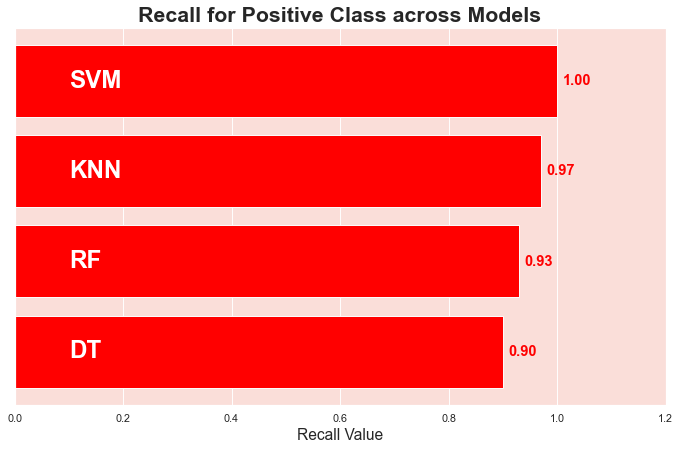

In [52]:

results.sort_values(by='recall_1', ascending=True, inplace=True)
recall_1_scores = results['recall_1']

fig, ax = plt.subplots(figsize=(12, 7), dpi=70)
ax.barh(results.index, recall_1_scores, color='red')

for i, (value, name) in enumerate(zip(recall_1_scores, results.index)):
    ax.text(value + 0.01, i, f"{value:.2f}", ha='left', va='center', fontweight='bold', color='red', fontsize=15)
    ax.text(0.1, i, name, ha='left', va='center', fontweight='bold', color='white', fontsize=25)

ax.set_yticks([])

ax.set_xlim([0, 1.2])

plt.title("Recall for Positive Class across Models", fontweight='bold', fontsize=22)
plt.xlabel('Recall Value', fontsize=16)
plt.show()


### Inference:
- Heart Disease dataset is used for prediction using 4 models: Support Vector Machine, K Nearest Neighbor, Random Forest, Decision Trees.
- Result show SVM performed best among 4 given models.